**Hey Kaggle, I'm new to Python and Data Science, so any comments or advice would help me a lot ! Thanks ! **

**The aim of this kernel is to get a better idea of what this dataset is made of and to explore the relations between variables.**

**This is only a first draft, I will add way more content later !**

In [1]:
#Package importation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import squarify 

In [2]:
#Data Importation
train = pd.read_csv('./data/train.tsv',delimiter='\t', dtype={'item_description': str})

**Firstly, we'll check some general informations about our dataset :**

In [3]:
train.shape
train.info()
train.isnull().sum()
train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


So, we've very few variables (only 6 without ID) and relativly a lot of observations (1 482 535).
We've variables of different types (continuous, binary and caterorial).

**Do each item name is unique ? **

In [4]:
i = train.name.value_counts().size
print ('Number of distinct items names : ', i)

Number of distinct items names :  1225273


The answer is no, several items share the same name.

**How many items categories do we have ?**

In [5]:
nb_cat = train.category_name.value_counts().size
print ('We have', nb_cat, 'different items categories.')

We have 1287 different items categories.


**Top 10 categories by number of product :**

Text(0.5, 0, 'Number of product in the category')

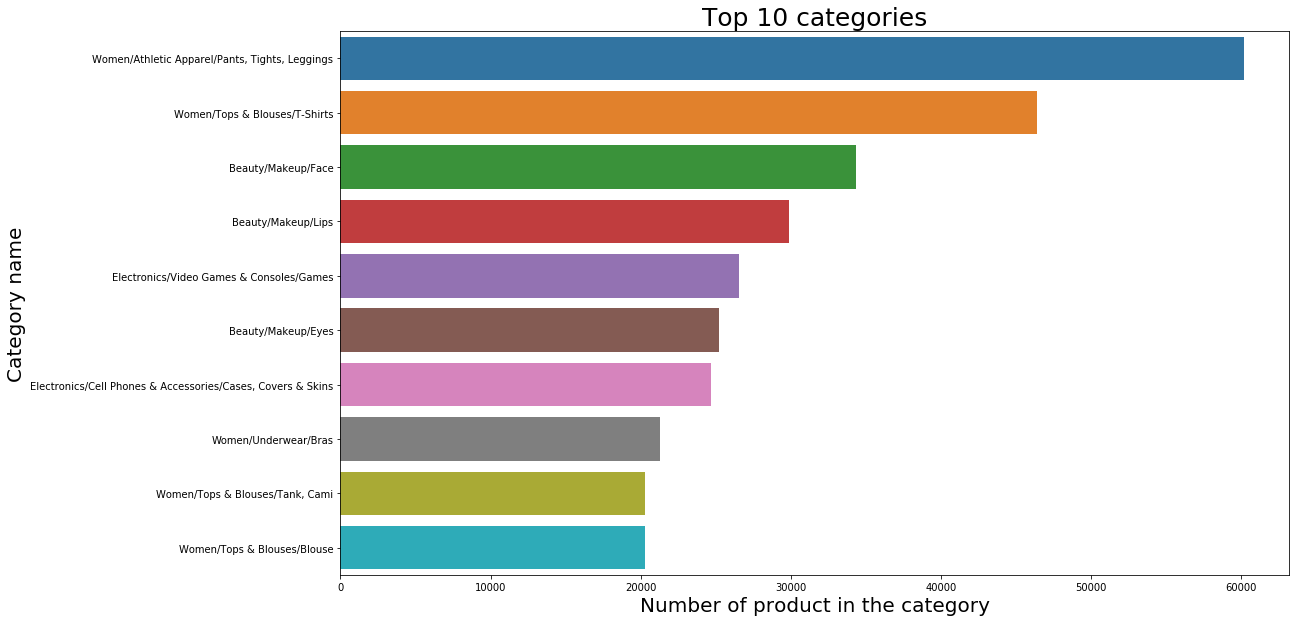

In [6]:
plt.figure(figsize=(17,10))
sns.countplot(y = train.category_name, \
              order = train.category_name.value_counts().iloc[:10].index, \
                                                      orient = 'v')
plt.title('Top 10 categories', fontsize = 25)
plt.ylabel('Category name', fontsize = 20)
plt.xlabel('Number of product in the category', fontsize = 20)

**Treemap of the categories :**

(0.0, 100.0, 0.0, 100.0)

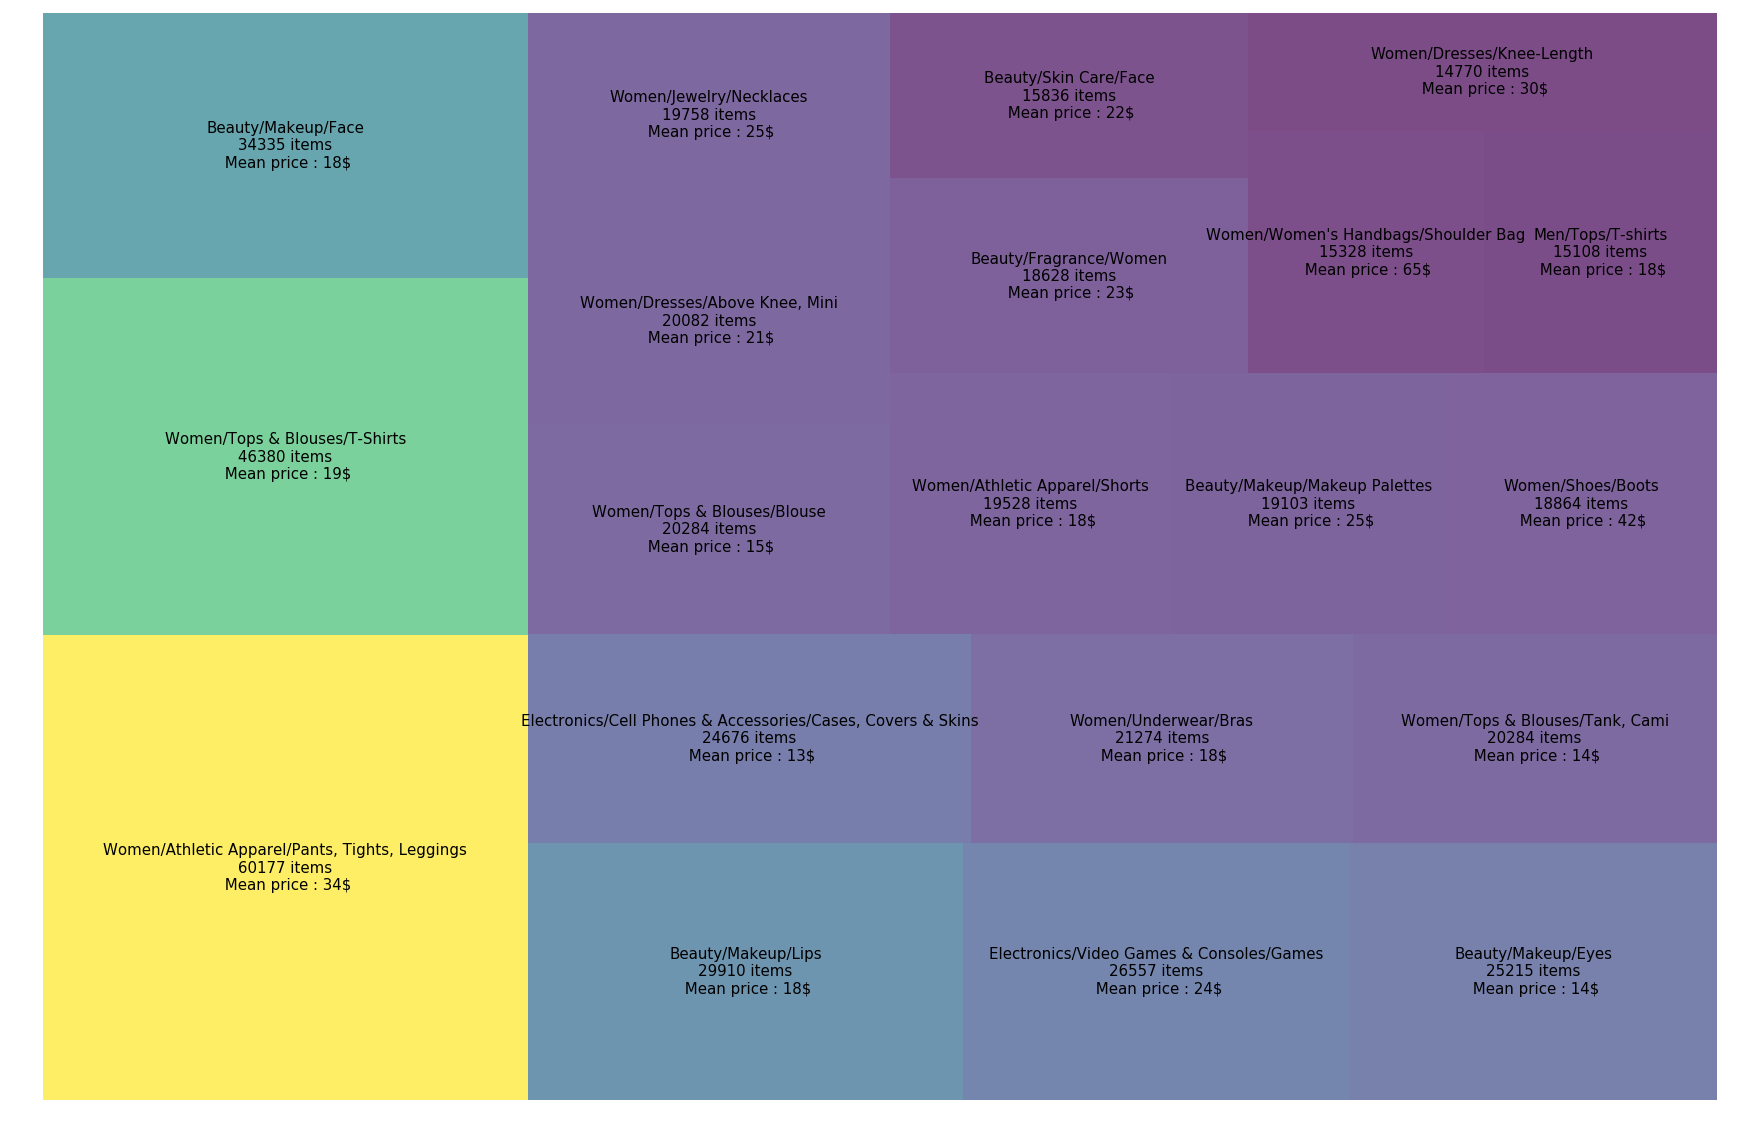

In [7]:
# Size of each category
cats = pd.DataFrame(train.category_name.value_counts())
cats.reset_index(level = 0, inplace=True)
cats = cats.sort_values(by='category_name', ascending = False).head(20)
cats.columns =('category_name', 'size')

# Price by category
group = train.groupby(train.category_name)
mean_price = group.price.mean()
mean_price = pd.DataFrame(mean_price)
mean_price.reset_index(level = 0, inplace=True)

# Merging
cats = pd.merge(cats, mean_price, how='left', on = 'category_name')

# Colors setting
cmap = matplotlib.cm.viridis
mini=min(cats['size'])
maxi=max(cats['size'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in cats['size']]

# Labels setting
labels = ["%s\n%d items\n Mean price : %d$" % (label) \
          for label in zip(cats['category_name'], cats['size'], cats['price'])]

# Plotting
plt.figure(figsize=(30,20))
plt.rc('font', size=15)
squarify.plot(sizes = cats['size'], label = labels, alpha = .7, color=colors)
plt.axis('off')

**Top 20 categories by average price :**

Text(0.5, 0, 'Mean price')

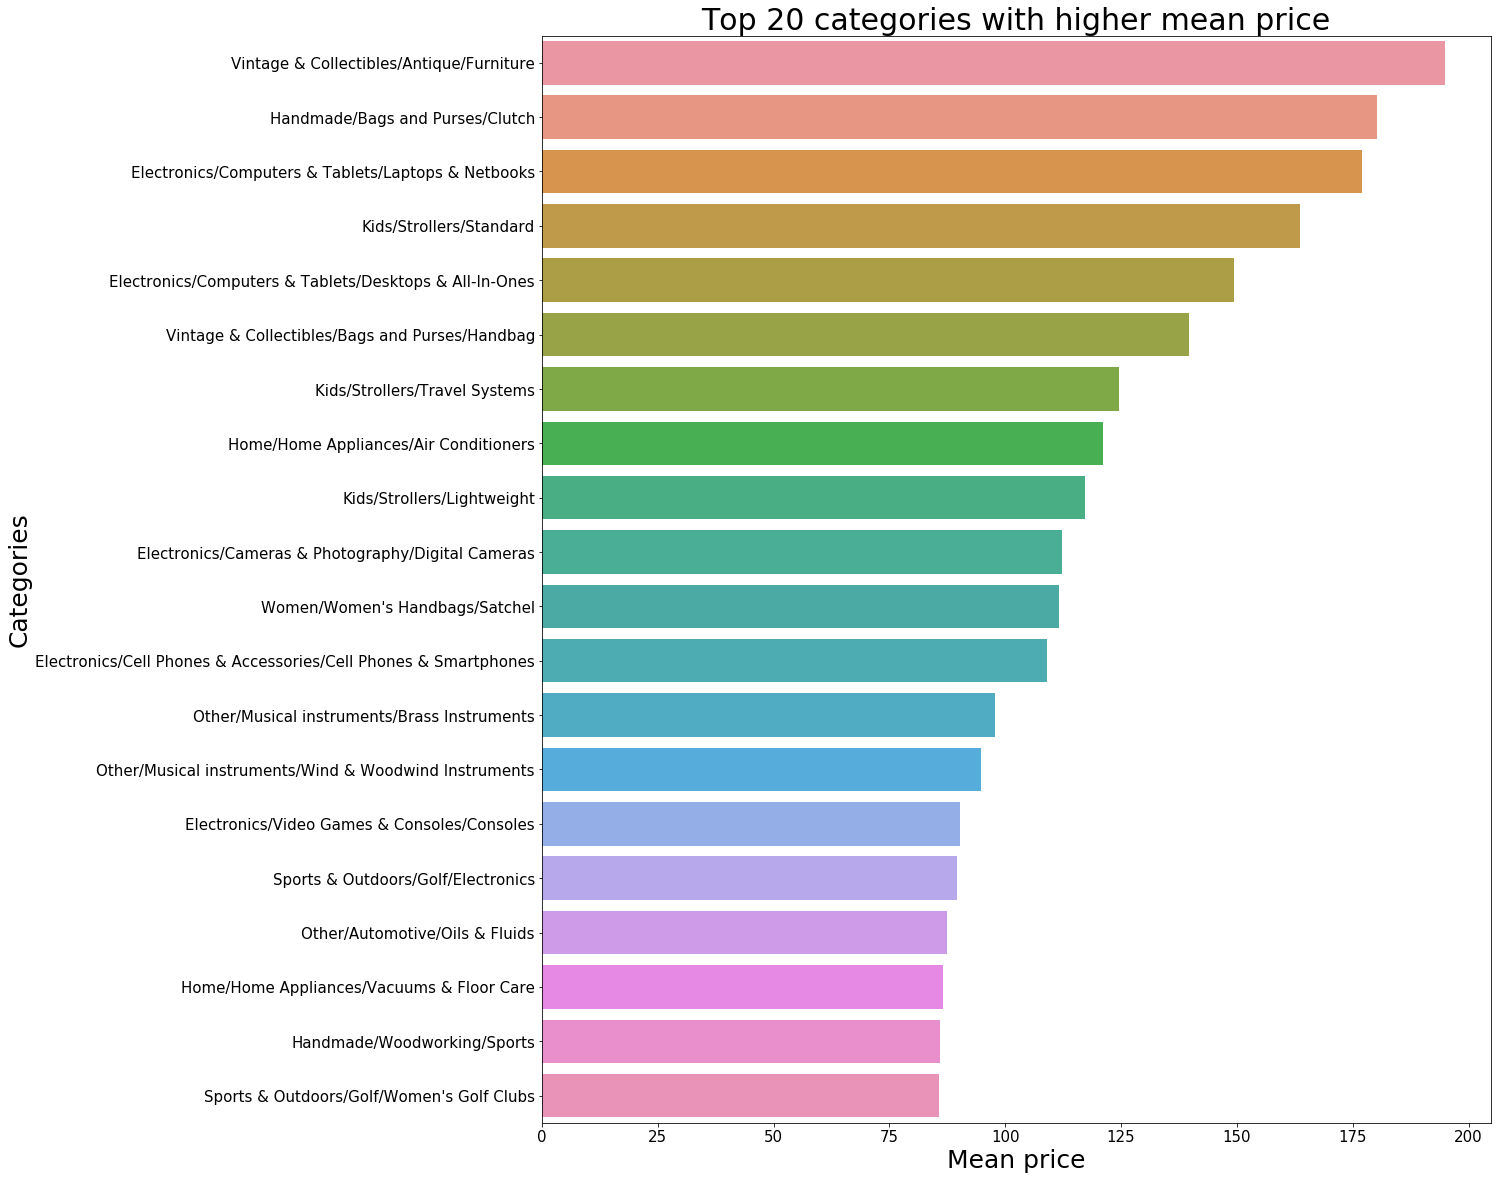

In [8]:
group = train.groupby(train.category_name)
mean_price = pd.DataFrame(group.price.mean())
mean_price = mean_price.sort_values(by='price', ascending = False).head(20)
mean_price.reset_index(level = 0, inplace=True)

plt.figure(figsize=(17,20))
sns.barplot(x = 'price', y = 'category_name', data = mean_price, orient = 'h')
plt.title('Top 20 categories with higher mean price', fontsize = 30)
plt.ylabel('Categories', fontsize = 25)
plt.xlabel('Mean price', fontsize = 25)

**So, some categories are expensive, but most are cheap ?**

Text(0.5, 0, 'Mean price of each category')

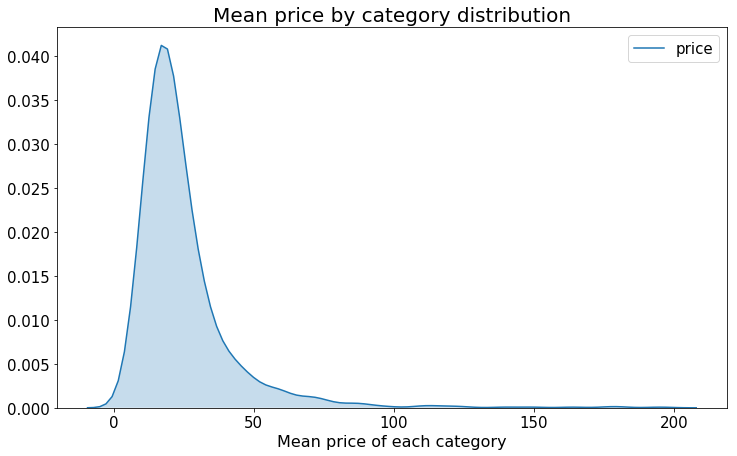

In [9]:
mean_price_2 = pd.DataFrame(group.price.mean())
mean_price_2.reset_index(level = 0, inplace=True)

plt.figure(figsize =(12,7))
sns.kdeplot(mean_price_2.price, shade = True)
plt.title('Mean price by category distribution', fontsize = 20)
plt.xlabel('Mean price of each category', fontsize = 16)

Our expectations seems right, the most of the categories are composed of cheap items (less than 50$). 

**Can we split those categories by level ?**
Items seems to be classify with an tree structure of 3 levels.

Text(0, 0.5, '')

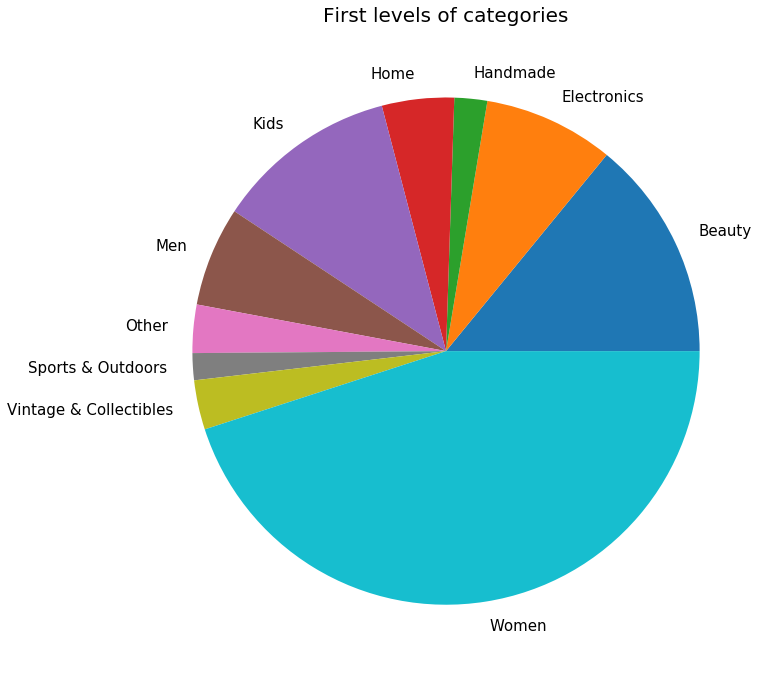

In [10]:
train['cat1'] = train.category_name.str.extract('([^/]+)/[^/]+/[^/]+')
train['cat2'] = train.category_name.str.extract('([^/]+/[^/]+)/[^/]+')

plt.figure(figsize = (10,12))
train.name.groupby(train.cat1).count().plot(kind = 'pie')
plt.title ('First levels of categories', fontsize = 20)
plt.axis('equal')
plt.ylabel('')

**Zoom on the second level :**

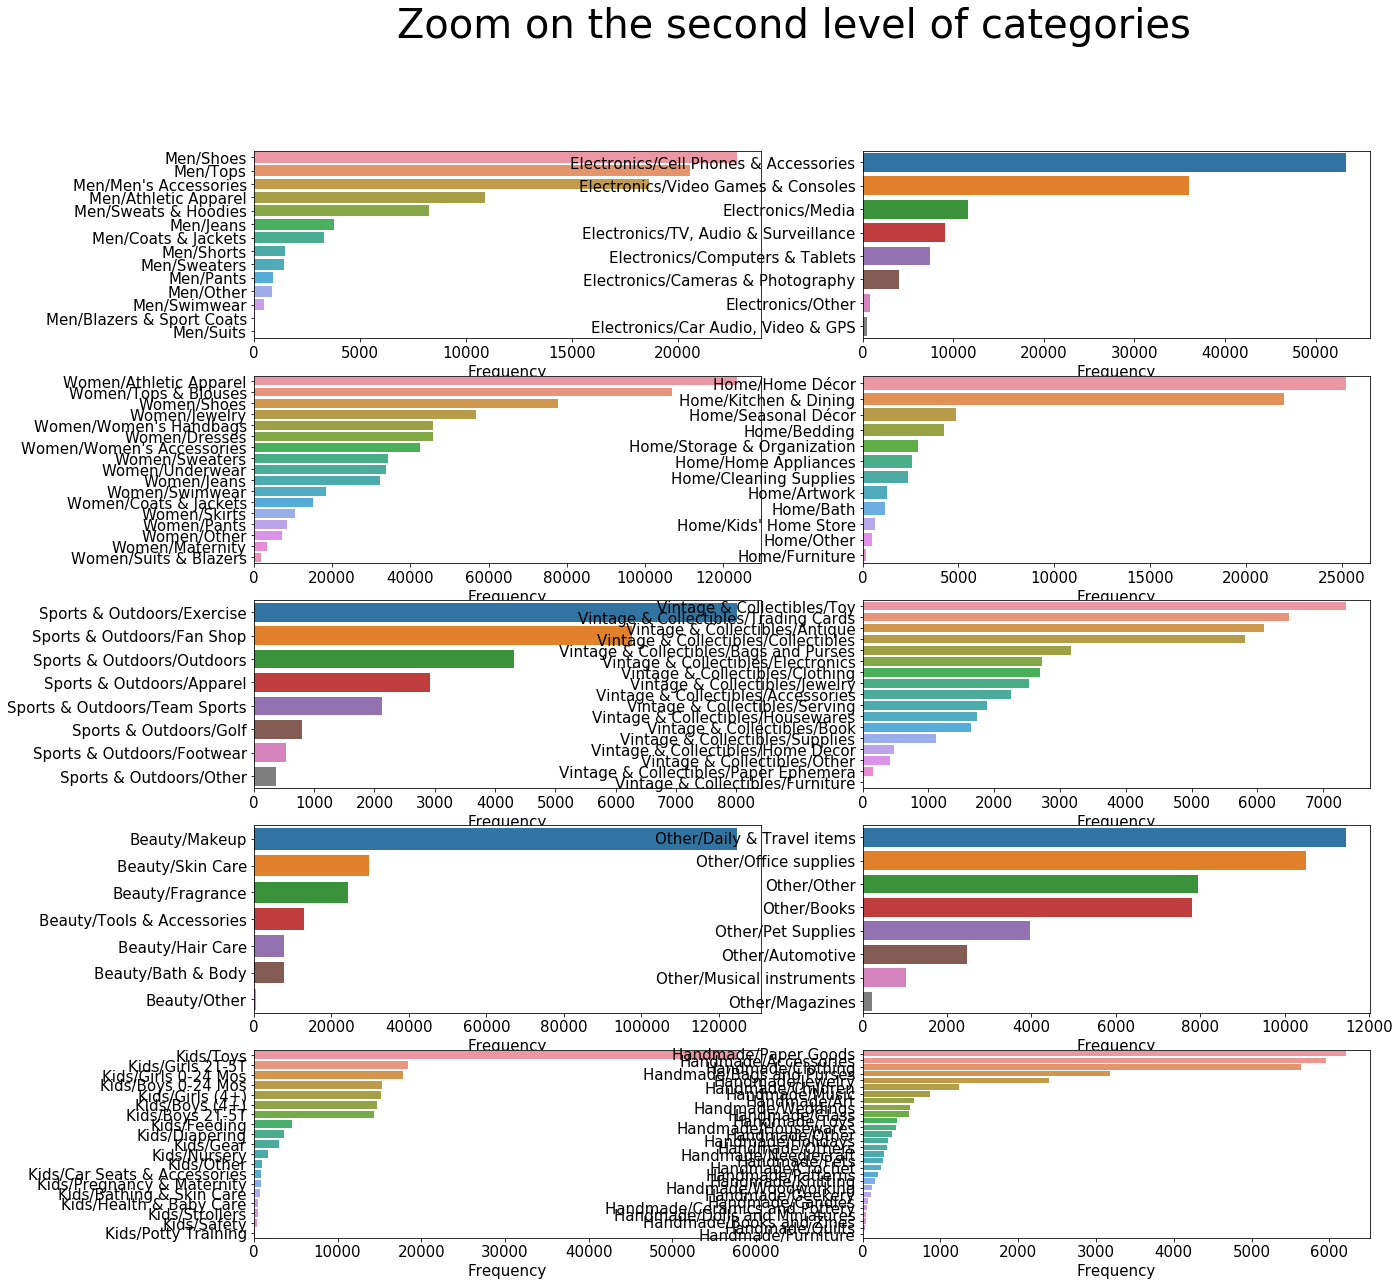

In [11]:
# We stock each variable's repartition into a dictionary
alldf = {}
for col in train.cat1[train.cat1.isnull() == False].unique() :

    temp = train.cat2[train['cat1'] == col]
    temp = pd.DataFrame(temp.value_counts().reset_index())
    
    alldf[col] = temp

# Now we can plot it    
i = 0
fig, axs = plt.subplots(5,2, figsize=(20,20))   
plt.suptitle('Zoom on the second level of categories', fontsize = 40) 

for cat in alldf:
    temp = alldf[cat]
    sns.barplot('cat2', 'index', data = temp, ax = axs.flatten()[i])
    axs.flatten()[i].set_ylabel('')
    axs.flatten()[i].set_xlabel('Frequency')
    i+=1    

So now we know what are the most popular second level categories and we already have the information about the third level (full category). It could be interessing to have a deeper look at the price of the subcategories.

**Prices of the first level of categories**

Text(0.5, 0, 'Price')

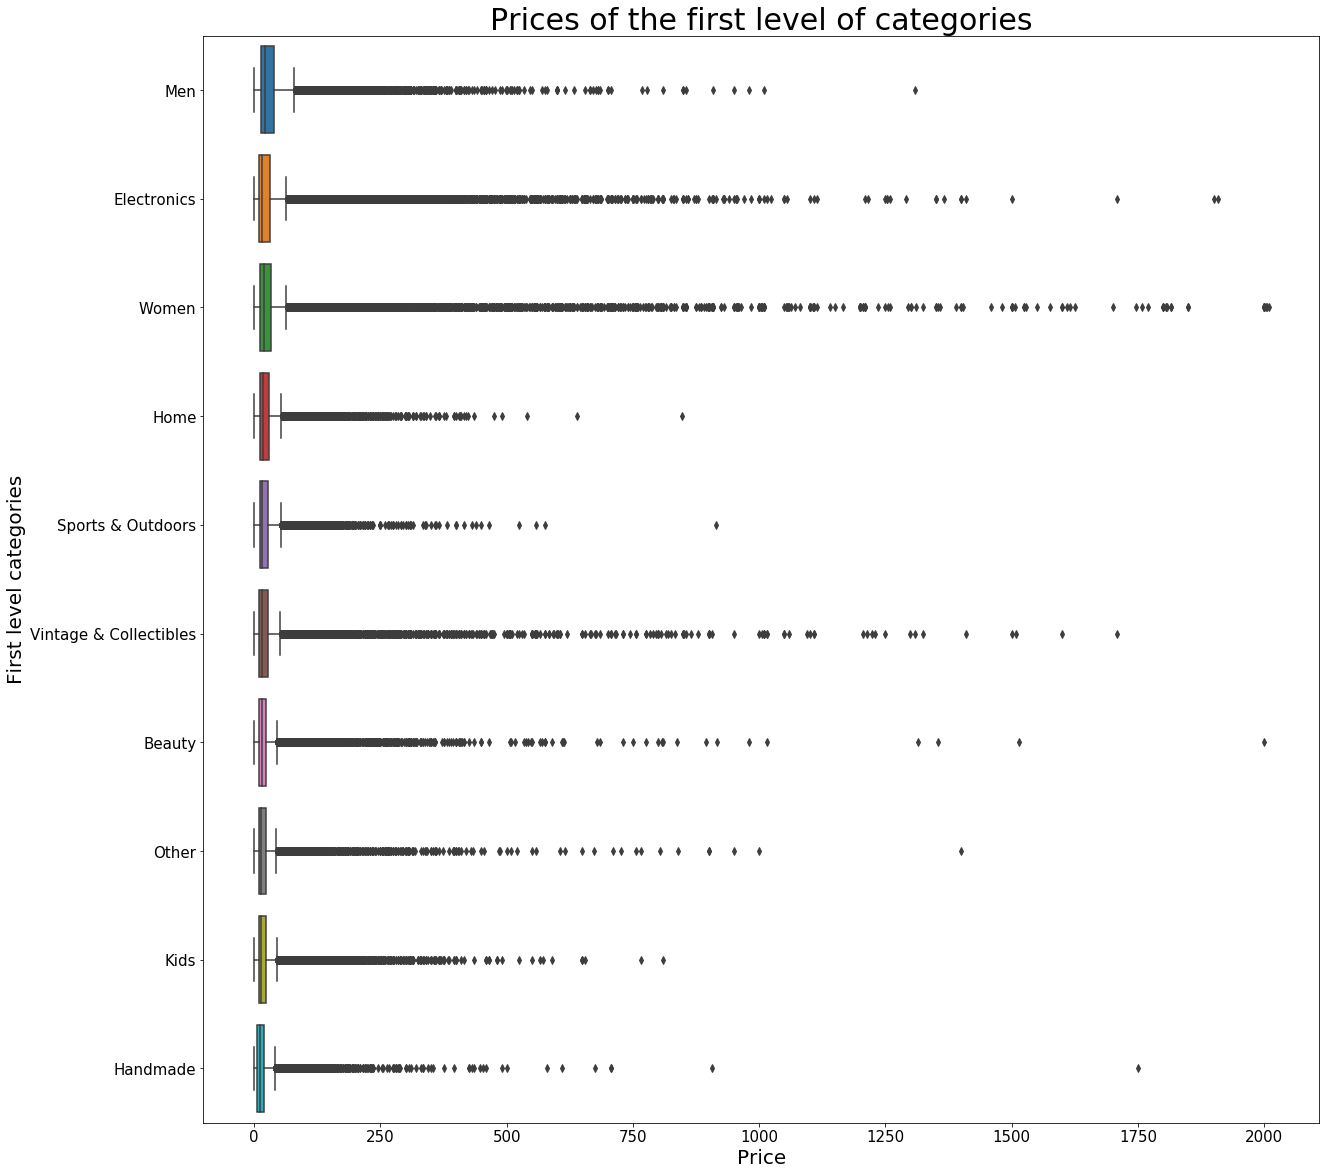

In [12]:
plt.figure(figsize=(20,20))
sns.boxplot( x = 'price' , y = 'cat1', data = train, orient = 'h')
plt.title('Prices of the first level of categories', fontsize = 30)
plt.ylabel ('First level categories', fontsize = 20)
plt.xlabel ('Price', fontsize = 20)

Top 15 second levels categories with highest prices 

Text(0.5, 0, 'Price')

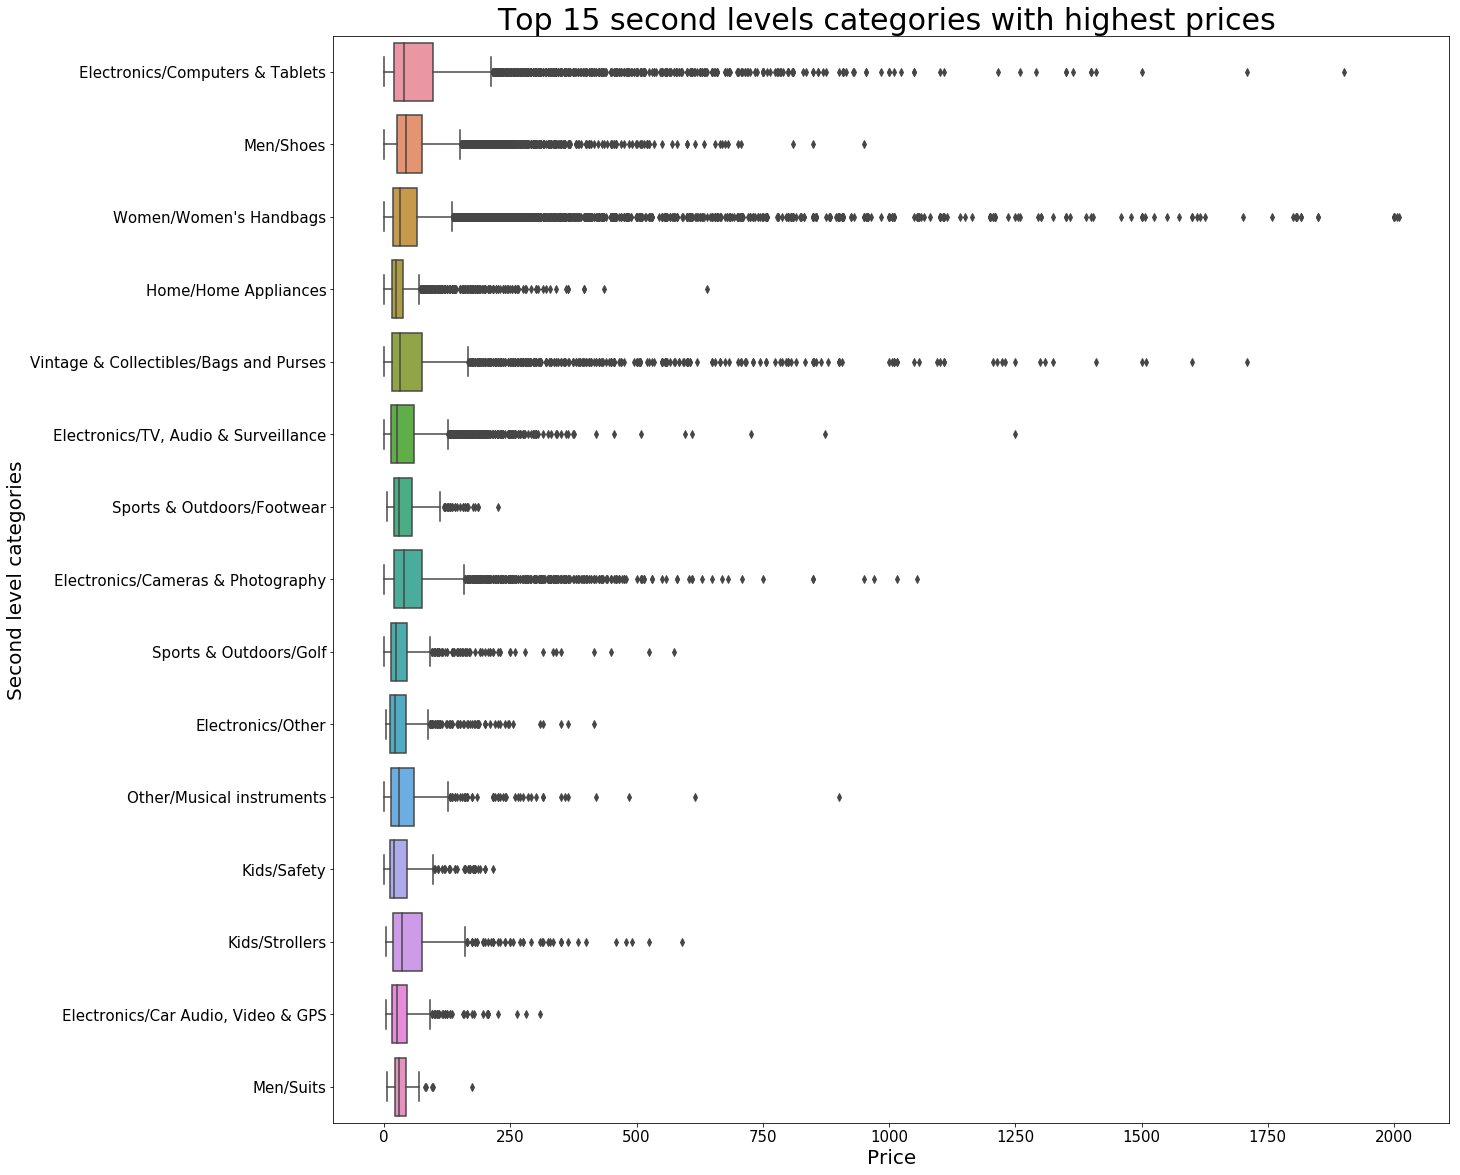

In [13]:
#Firstly, we create a ranking of our level 2 categories, by price
level2 =  train.groupby('cat2')
rank_level2 = pd.DataFrame(level2.mean()).sort_values(by='price')

#Then, we stock the top 15 most expensive into a list
top_cat2 = rank_level2.tail(15).reset_index()
top_cat2_list = top_cat2.cat2.unique().tolist()
#We don't only want mean price by category, but all basics statistics, so we need the full series
top_cat2_full = train.loc[train['cat2'].isin(top_cat2_list)]

#We can now plot it !
plt.figure(figsize=(20,20))
sns.boxplot(y ='cat2',x= 'price', data = top_cat2_full, orient = 'h')
plt.title('Top 15 second levels categories with highest prices ', fontsize = 30)
plt.ylabel ('Second level categories', fontsize = 20)
plt.xlabel ('Price', fontsize = 20)

Top 15 second levels categories with lowest prices 

Text(0.5, 0, 'Price')

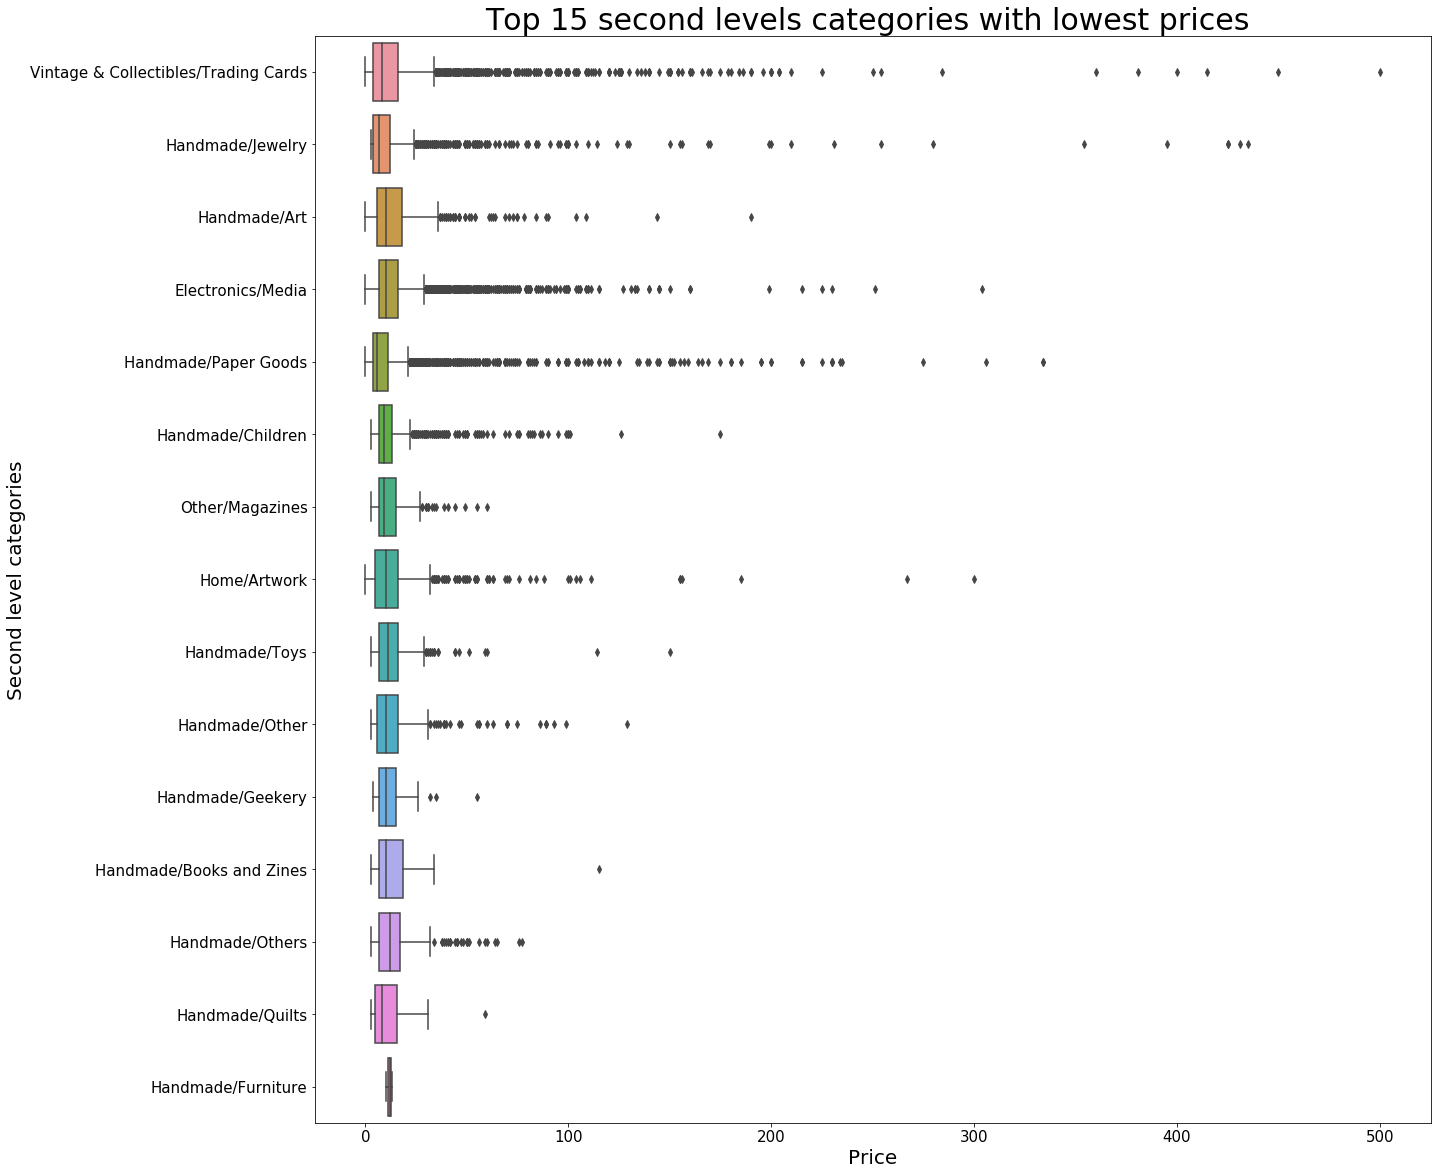

In [14]:
botom_cat2 = rank_level2.head(15).reset_index()
botom_cat2_list = botom_cat2.cat2.unique().tolist()
botom_cat2_full = train.loc[train['cat2'].isin(botom_cat2_list)]

plt.figure(figsize=(20,20))
sns.boxplot(y ='cat2',x= 'price', data = botom_cat2_full, orient = 'h')
plt.title('Top 15 second levels categories with lowest prices ', fontsize = 30)
plt.ylabel ('Second level categories', fontsize = 20)
plt.xlabel ('Price', fontsize = 20)

Any subcategories (either first or second level) is "always expensive". On the other side, some subcategories, espacialy handmade, look widely cheap.

**How many different brands do we have ?**

In [16]:
i = train.brand_name.value_counts().size
print('We have', i, 'different brands.') 

We have 4809 different brands.


**Top 10 brands by number of products :**

Text(0.5, 0, 'Number of product of the brand')

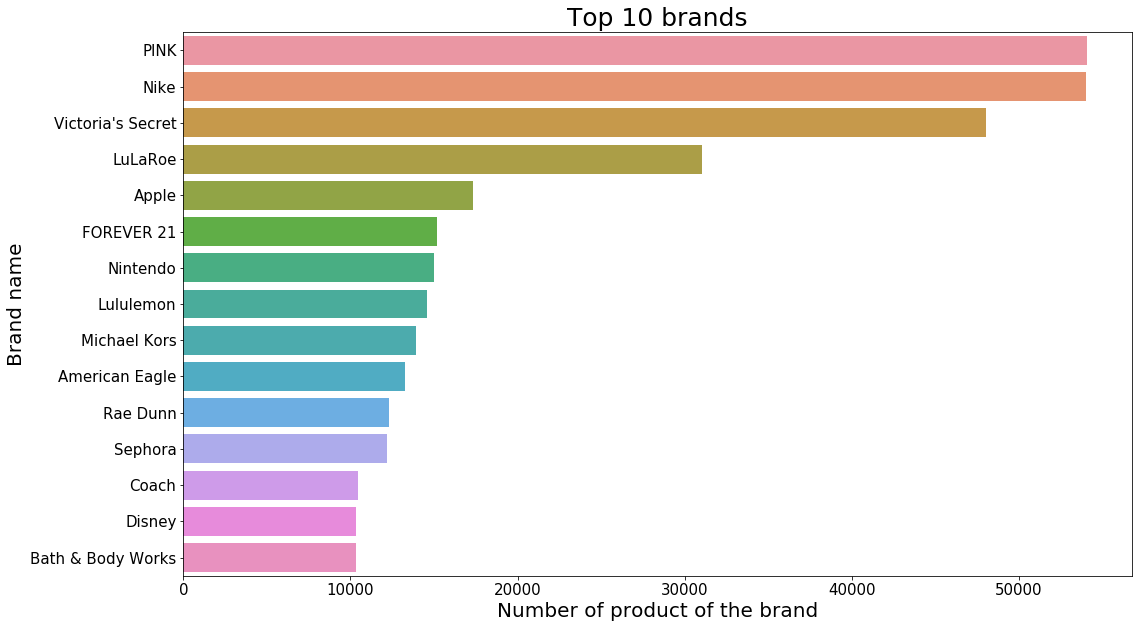

In [18]:
plt.figure(figsize=(17,10))
sns.countplot(y = train.brand_name, \
              order = train.brand_name.value_counts().iloc[:15].index, \
                                                      orient = 'v')
plt.title('Top 10 brands', fontsize = 25)
plt.ylabel('Brand name', fontsize = 20)
plt.xlabel('Number of product of the brand', fontsize = 20)

**Which brands are most expensive ?**

Text(0.5, 0, 'Mean price')

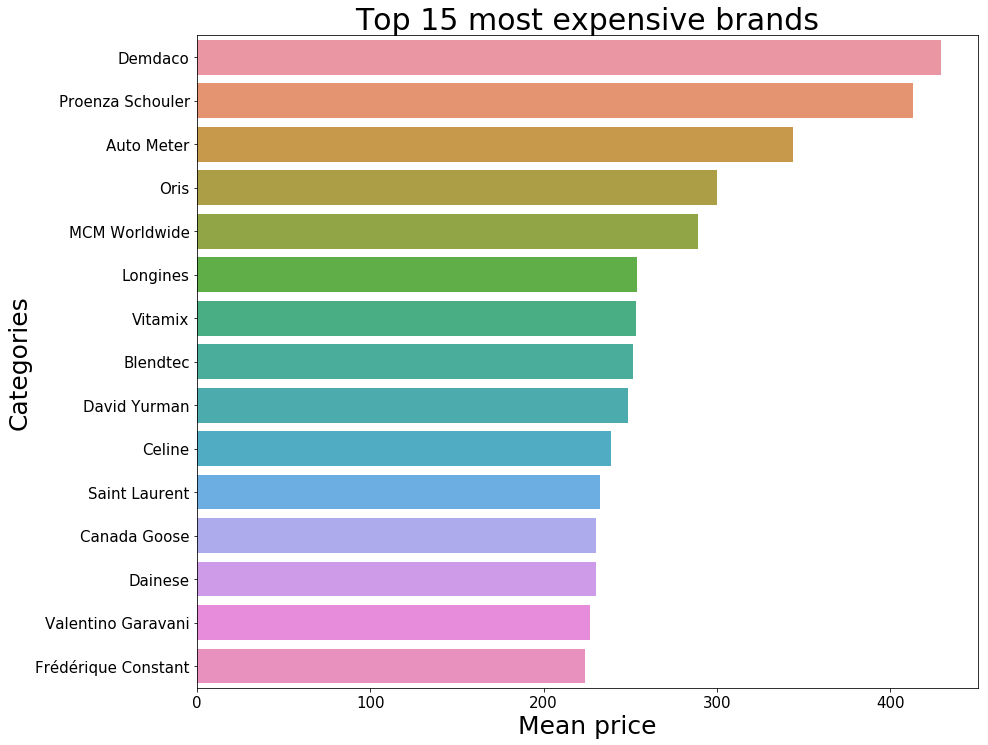

In [19]:
group = train.groupby(train.brand_name)
ranking = pd.DataFrame(group.price.mean())
ranking.reset_index(level = 0, inplace=True)
ranking = ranking.sort_values(by='price', ascending = False).head(15)

plt.figure(figsize=(14,12))
sns.barplot(x = 'price', y = 'brand_name', data = ranking, orient = 'h')
plt.title('Top 15 most expensive brands', fontsize = 30)
plt.ylabel('Categories', fontsize = 25)
plt.xlabel('Mean price', fontsize = 25)

**More details on brands with a treemap :**

(0.0, 100.0, 0.0, 100.0)

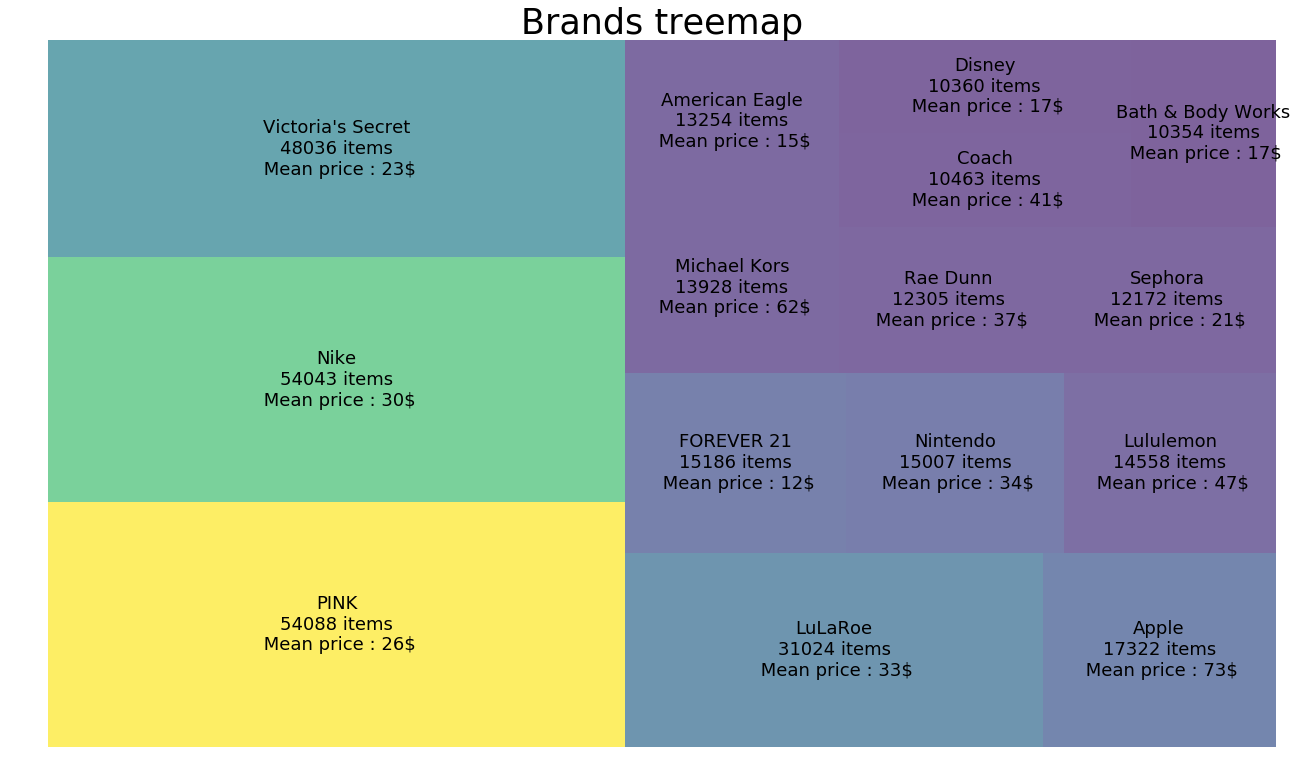

In [20]:
# Brands sorted by number of item
brands = pd.DataFrame(train.brand_name.value_counts())
brands.reset_index(level = 0, inplace=True)
brands = brands.sort_values(by='brand_name', ascending = False).head(15)
brands.columns = ('brand_name', 'number_of_item')

# Brands by price
group = train.groupby (train.brand_name)
brands_prices = pd.DataFrame(group.price.mean())
brands_prices.reset_index(level = 0, inplace=True)

# Merging
brands = pd.merge(brands, brands_prices, how = 'left', on = 'brand_name')

# Labels setting
labels = ["%s\n%d items\n Mean price : %d$" % (label) \
          for label in zip(brands['brand_name'], brands['number_of_item'], brands['price'])]

# Plotting
plt.figure(figsize=(22,13))
plt.rc('font', size=18)
squarify.plot(sizes = brands['number_of_item'], label = labels, alpha = .7, color=colors)
plt.title('Brands treemap', fontsize = 35)
plt.axis('off')

**What's about the variable 'item_condition_id' ?**

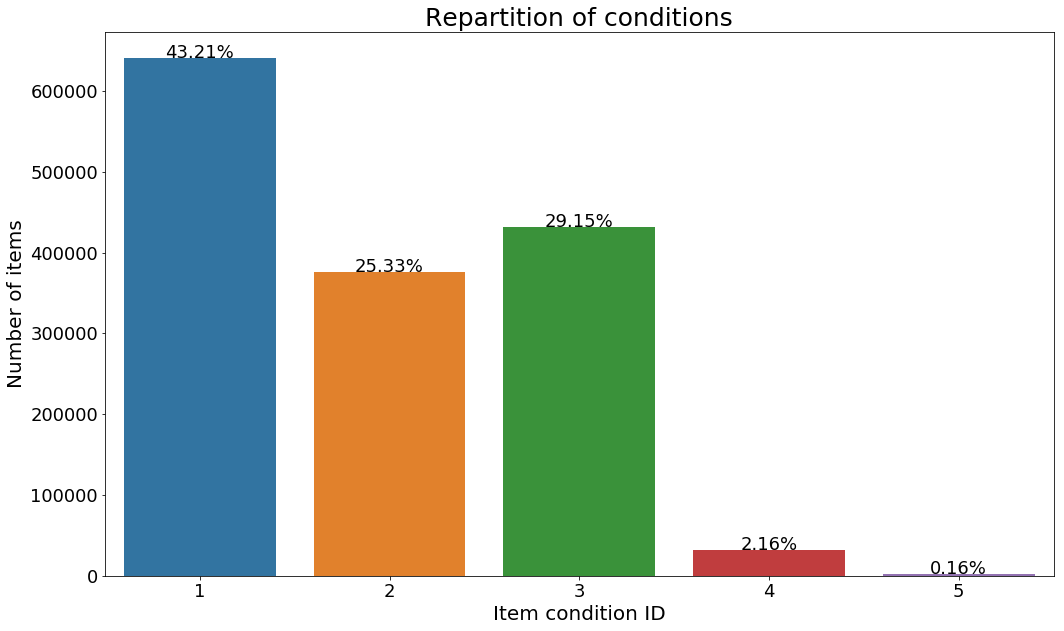

In [21]:
total = float(len(train.item_condition_id))

plt.figure(figsize=(17,10))
ax = sns.countplot(train.item_condition_id)

plt.title('Repartition of conditions', fontsize = 25)
plt.ylabel('Number of items', fontsize = 20)
plt.xlabel('Item condition ID', fontsize = 20)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

**Now let's analyze the price :**

In [22]:
pd.options.display.float_format = '{:.2f}'.format
train.price.describe()

count   1482535.00
mean         26.74
std          38.59
min           0.00
25%          10.00
50%          17.00
75%          29.00
max        2009.00
Name: price, dtype: float64

In [23]:
i = train.price.quantile(0.99)
print ('The 99th quantile is :', i)

The 99th quantile is : 170.0


Text(0.5, 1.0, 'Simple distribution plot of the price')

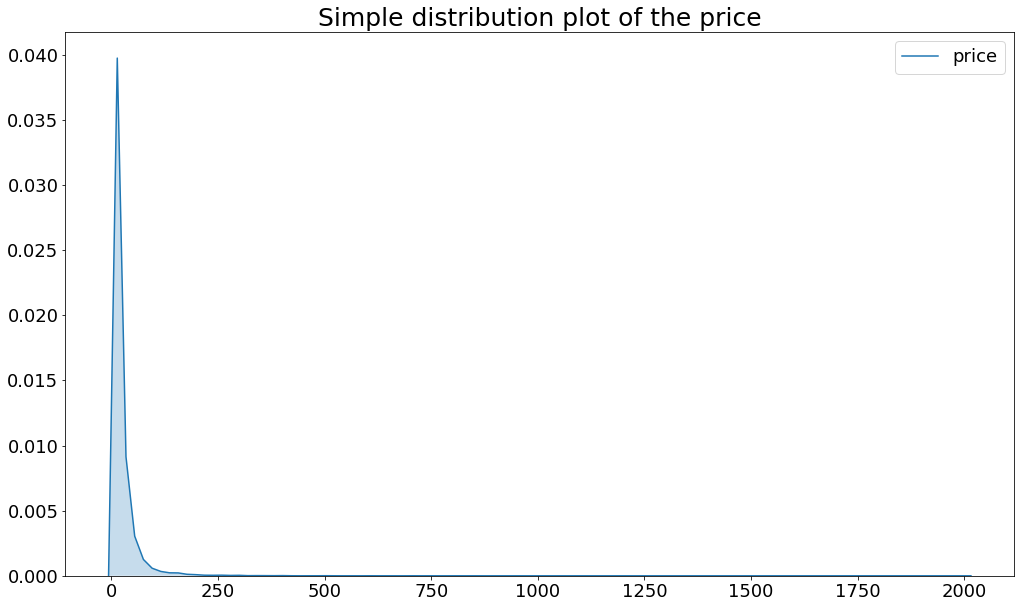

In [24]:
plt.figure(figsize=(17,10))
sns.kdeplot(train.price, shade = True)
plt.title('Simple distribution plot of the price', fontsize =25)

Most of items have a low price (75% under 29$), but there are so very high extremum.
Strangely, a lot of items seems to have a price of 0.

**Let's count them :**

In [25]:
i = train.price[train.price == 0].count()
print (i, 'items have a price of zero.')

874 items have a price of zero.


**What are their top categories ?**

Text(0.5, 0, 'Number of product in the category')

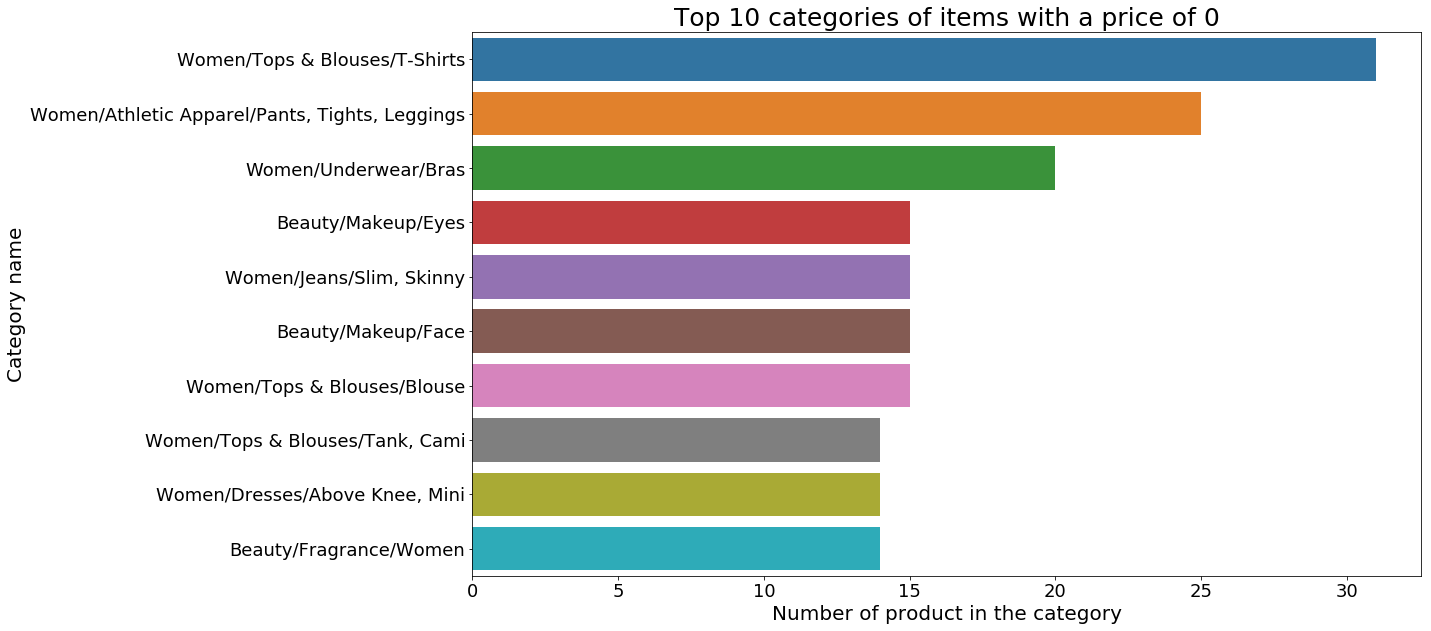

In [26]:
price_of_zero = train.loc[train.price == 0]

plt.figure(figsize=(17,10))
sns.countplot(y = price_of_zero.category_name, \
              order = price_of_zero.category_name.value_counts().iloc[:10].index, \
                                                      orient = 'v')
plt.title('Top 10 categories of items with a price of 0', fontsize = 25)
plt.ylabel('Category name',  fontsize = 20)
plt.xlabel('Number of product in the category',  fontsize = 20)

It's actualy very similar to the top 10 categories of the whole dataset. So, having a price of zero is not specific to a category

**What are the most expensive items ?**

/home/faisal/anaconda3/envs/gpu/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


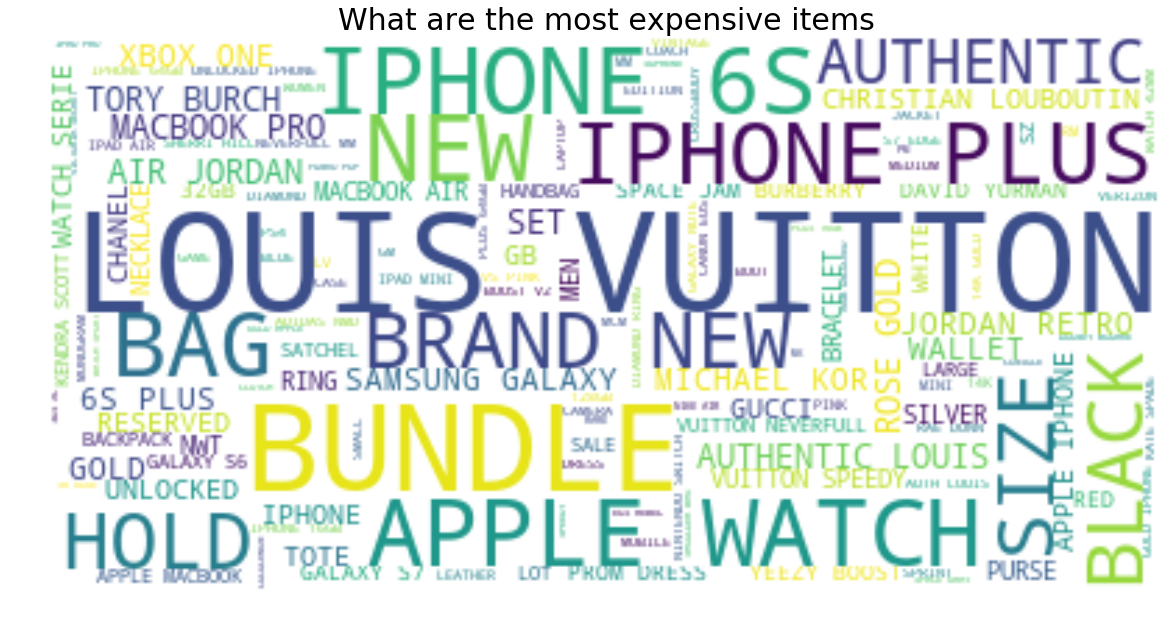

In [27]:
exp = train[train['price'] > 200]
exp.name = exp.name.str.upper()

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)

wc.generate(" ".join(str(s) for s in exp.name.values))

plt.figure(figsize=(20,12))
plt.title('What are the most expensive items', fontsize = 30)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

**What's about shipping ?**

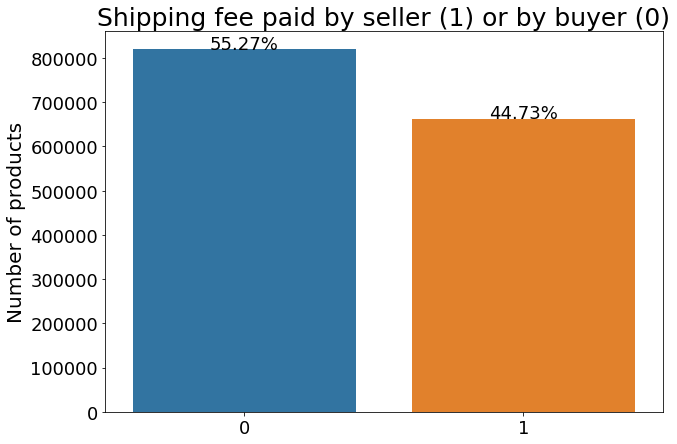

In [28]:
total = float(len(train.shipping))

plt.figure(figsize=(10,7))
ax = sns.countplot(train.shipping)
plt.title('Shipping fee paid by seller (1) or by buyer (0)', fontsize = 25)
plt.ylabel('Number of products', fontsize = 20)
plt.xlabel('')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

**Does shipping depends of price ?**

Text(0, 0.5, 'Price without outliers')

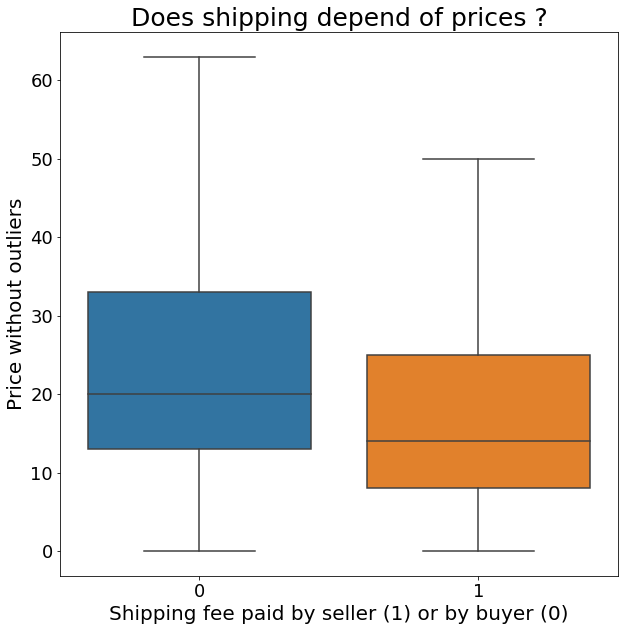

In [29]:
plt.figure(figsize=(10,10))
sns.boxplot(x=train.shipping, y = train.price, showfliers=False, orient = 'v')
plt.title('Does shipping depend of prices ?', fontsize = 25)
plt.xlabel('Shipping fee paid by seller (1) or by buyer (0)', fontsize = 20)
plt.ylabel('Price without outliers', fontsize = 20)

We use the option "showfliers=False" to flat the graph (because of those few very high prices).
As expected, seller are paying shipping fees more often when a item is more expensive.

**Can we get some informations out of the item description ?**

In [30]:
train['no_descrip'] = 0
train.loc[train.item_description=='No description yet', 'no_descrip'] = 1
i = str(round(train['no_descrip'].value_counts(normalize=True).iloc[1] * 100,2)) + '%'

print(i, 'of the items have no a description.')

5.56% of the items have no a description.


**Does the lack of a description give an information on the price of an item ?**

In [31]:
train['no_descrip'] = 0
train.loc[train.item_description=='No description yet', 'no_descrip'] = 1
i = str(round(train['no_descrip'].value_counts(normalize=True).iloc[1] * 100,2)) + '%'
print(i, 'of the items have no a description. \n')

i1 = str(round((train.no_descrip[train.price > 100].sum() / len(train.no_descrip))*100,2)) + '%'
i2 = str(round((train.no_descrip[train.price <= 100].sum() / len(train.no_descrip))*100,2)) + '%'

print('While', i2, 'of the items with a price lower than 100$ have no description, \n only',\
      i1, 'of the items with a price higher than 100$ have no description.')

5.56% of the items have no a description. 

While 5.48% of the items with a price lower than 100$ have no description, 
 only 0.08% of the items with a price higher than 100$ have no description.


**What words do people use ?**

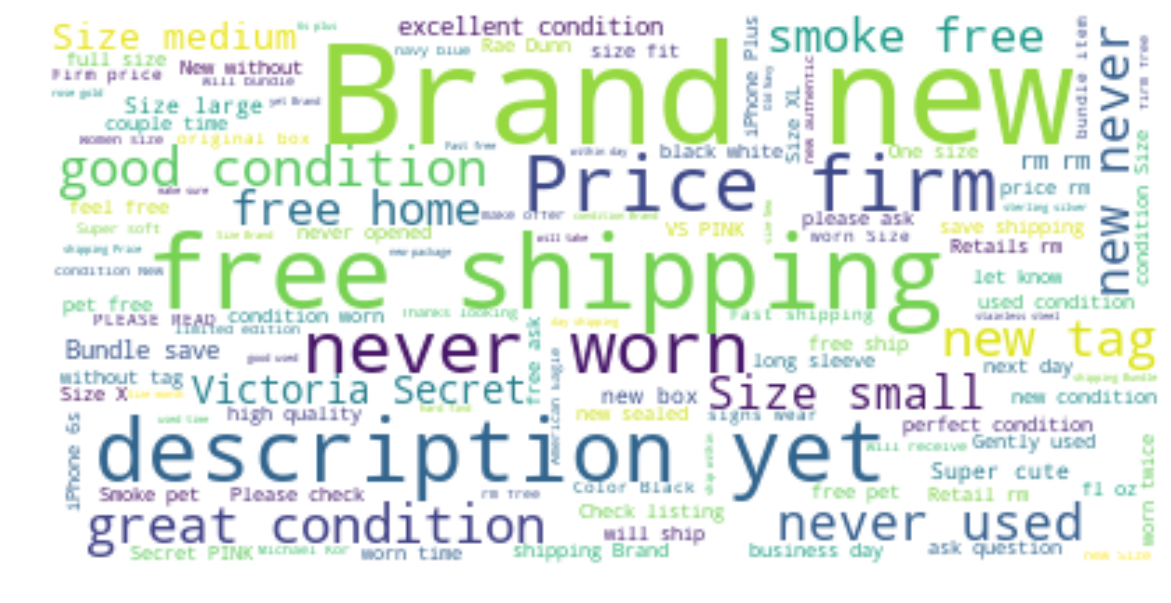

In [32]:
wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)

wc.generate(" ".join(str(s) for s in train.item_description.values))

plt.figure(figsize=(20,12))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')


**Can the length of the description give us some informations ?**

In [33]:
train['coms_length'] = train['item_description'].str.len()

# Some descriptive statistics
pd.options.display.float_format = '{:.2f}'.format
train['coms_length'].describe()

count   1482531.00
mean        145.71
std         174.45
min           1.00
25%          40.00
50%          86.00
75%         174.00
max        1046.00
Name: coms_length, dtype: float64

Text(0.5, 0, 'Description length')

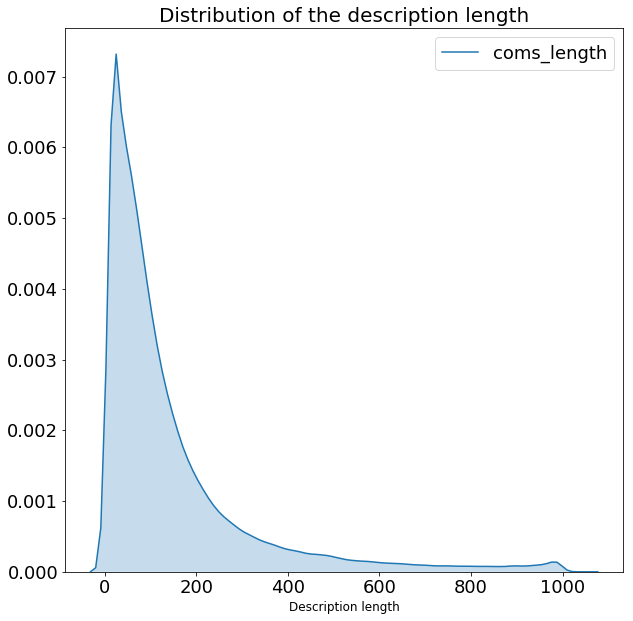

In [35]:
# The full distribution
plt.figure(figsize=(10,10))
sns.kdeplot(train['coms_length'].fillna(0), shade = True)
plt.title ('Distribution of the description length', fontsize = 20)
plt.xlabel('Description length', fontsize = 12)

**Is there a correlation between description length and price ?**

/home/faisal/anaconda3/envs/gpu/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Price')

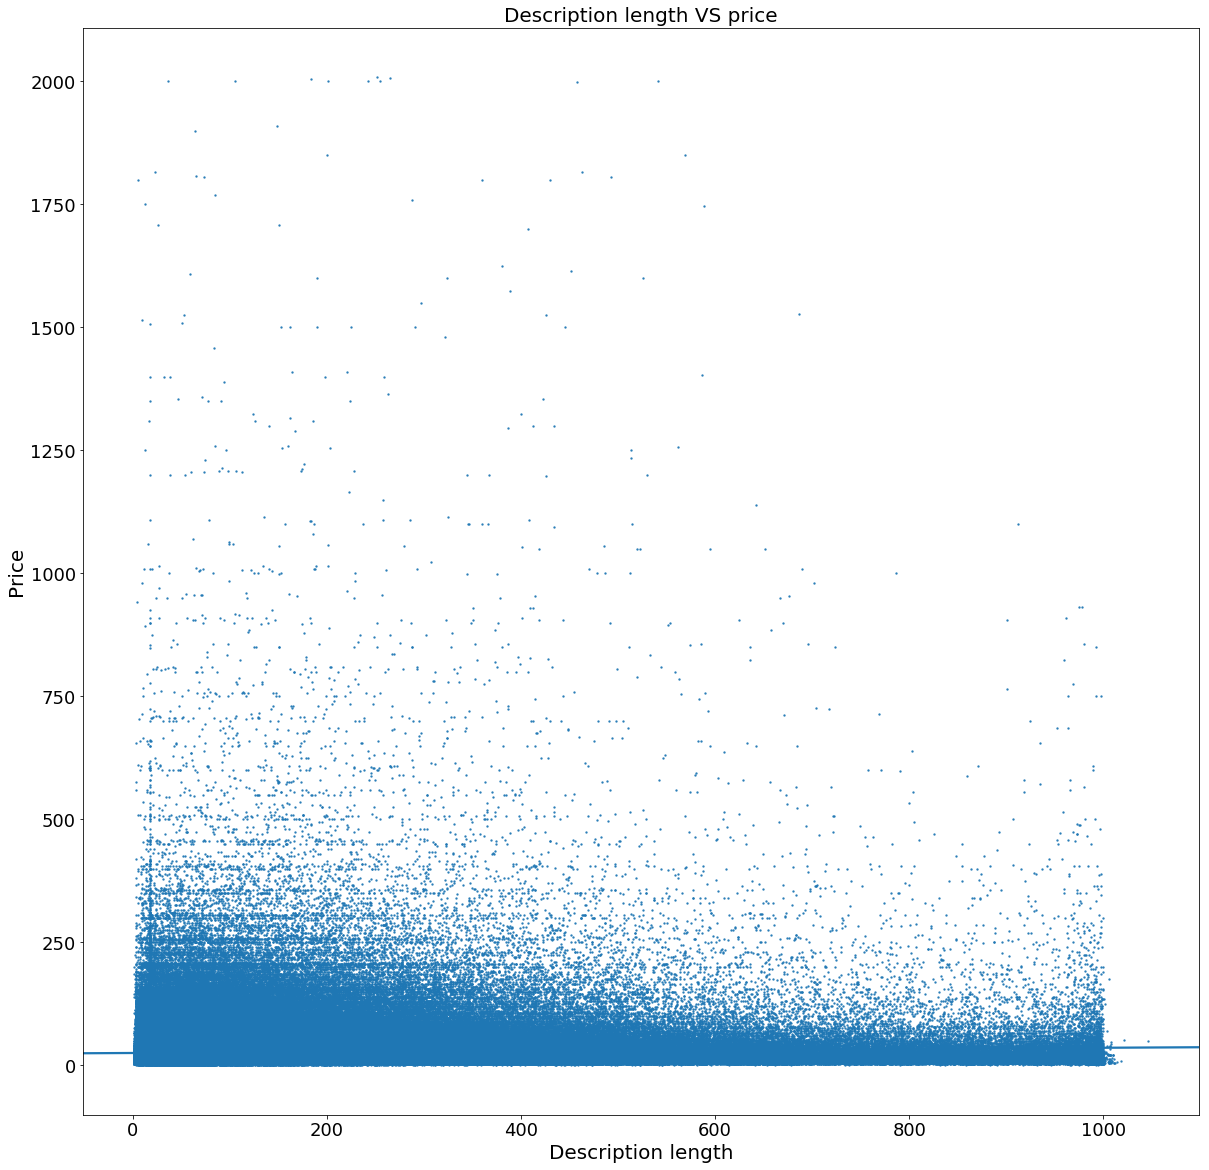

In [36]:
plt.figure(figsize=(20,20))
sns.regplot(x ='coms_length',y='price', data = train, scatter_kws={'s':2})
plt.title ('Description length VS price', fontsize = 20)
plt.xlabel('Description length', fontsize = 20)
plt.ylabel('Price', fontsize = 20)